We will be creating an algorithm that can classify between horses and humans. First we get the data from the Moroney Blog

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-07-13 14:47:12--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.126.128, 108.177.127.128, 172.217.218.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.126.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M  87.5MB/s    in 1.6s    

2020-07-13 14:47:14 (87.5 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



Next, we use the OS library to access the file system, and the zipfile to unzip the data.

In [ ]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('/tmp/horse-or-human')
zip_ref.close()

The contents of the zip are extracted to the base directory /tmp/horse-or-human, which in turn contatin horses and humans subdirectories.

A thing to notice is that, we didn't labeled the images as horses or humans. The ImageGenerator will automatically label them from the name of that subdirectory.

Let's define our directory for training

In [ ]:
# Directory with training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

['horse34-8.png', 'horse40-2.png', 'horse38-7.png', 'horse31-3.png', 'horse14-1.png', 'horse21-6.png', 'horse02-5.png', 'horse35-4.png', 'horse35-8.png', 'horse40-4.png']
['human16-30.png', 'human09-01.png', 'human03-26.png', 'human11-05.png', 'human16-12.png', 'human13-10.png', 'human04-01.png', 'human07-13.png', 'human01-07.png', 'human16-03.png']


In [ ]:
# Total number of horse and human images in the directories
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))


total training horse images: 500
total training human images: 527


In [ ]:
# Looking at couple of images
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# We'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# index for iterating over images 
pic_index = 0

Displaying a batch of 8 horse and 8 humnan pictures

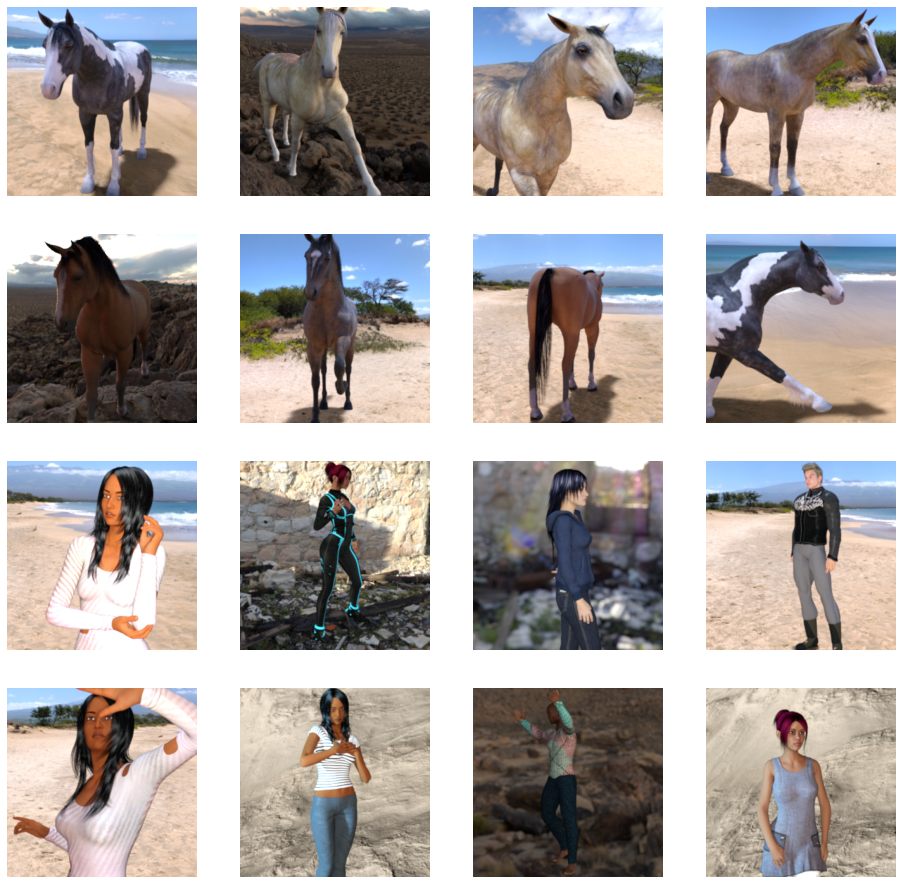

In [ ]:
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname)
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # setting up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off') # not displaying the gridlines

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

Now we define our model to detect humans and horses.

In [ ]:
import tensorflow as tf

model = tf.keras.models.Sequential([
        # The desired size of the image is 300x300 and the first convolution is as follows
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        # second convolution
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # third convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # fourth convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # fifth convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flattent the results to feed into a DNN
        tf.keras.layers.Flatten(),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        # 1 output neuron
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

Now we'll configure the specifications for model training. We will train our model with the binary_crossentropy loss along with a RMSprop optimizer with learning rate of 0.001

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

Now we set up the image generators that will read pictures in our source folders, convert them to float32 tensors, and feed them to our network. We will have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels(binary). We preprocess our preprocess our images by normalizing the pixel values to be in the [0,1] range. In Keras, this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. 

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Rescaling the images
train_datagen = ImageDataGenerator(rescale=1/255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',
    target_size=(300,300),
    batch_size=128,
    class_mode='binary'
)


Found 1027 images belonging to 2 classes.


Now we train the model for 15 epochs.

In [ ]:
history = model.fit(train_generator, steps_per_epoch=8, epochs=15, verbose=1)

Epoch 1/15
8/8 [==============================] - 5s 579ms/step - loss: 1.1480 - accuracy: 0.5083
Epoch 2/15
8/8 [==============================] - 5s 630ms/step - loss: 0.7875 - accuracy: 0.5684
Epoch 3/15
8/8 [==============================] - 6s 703ms/step - loss: 0.6230 - accuracy: 0.6865
Epoch 4/15
8/8 [==============================] - 5s 625ms/step - loss: 1.1020 - accuracy: 0.7475
Epoch 5/15
8/8 [==============================] - 6s 722ms/step - loss: 0.4133 - accuracy: 0.8921
Epoch 6/15
8/8 [==============================] - 5s 612ms/step - loss: 0.2673 - accuracy: 0.9010
Epoch 7/15
8/8 [==============================] - 5s 622ms/step - loss: 0.6594 - accuracy: 0.8509
Epoch 8/15
8/8 [==============================] - 6s 704ms/step - loss: 0.2674 - accuracy: 0.8936
Epoch 9/15
8/8 [==============================] - 5s 629ms/step - loss: 0.1051 - accuracy: 0.9600
Epoch 10/15
8/8 [==============================] - 5s 630ms/step - loss: 0.3719 - accuracy: 0.9099
Epoch 11/15
8/8 [==

Now we try the model on different images. We upload the files from our system and use the model to predict whether its a horse or human. 

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300,300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + ' is a human')
  else:
    print(fn + ' is a horse') 


Saving pexels-photo-3027243.jpeg to pexels-photo-3027243.jpeg
[1.]
pexels-photo-3027243.jpeg is a human


Visualizing the intermediate representations. 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


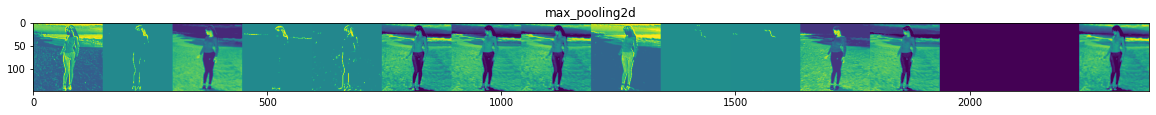

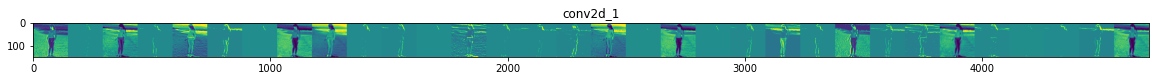

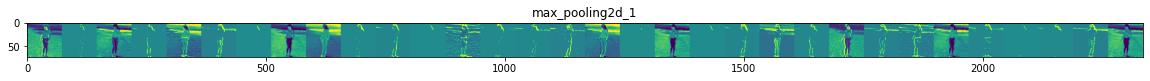

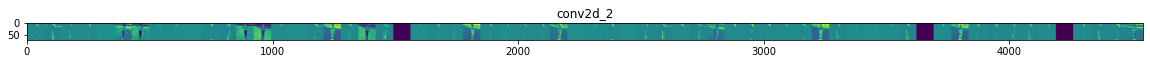

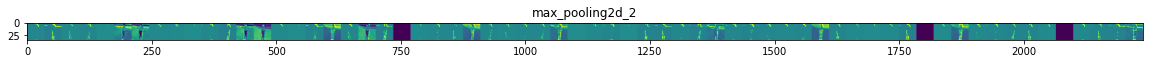

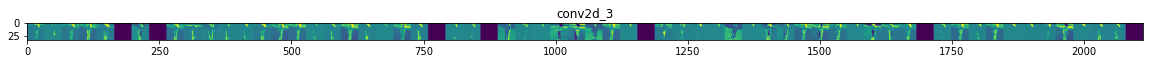

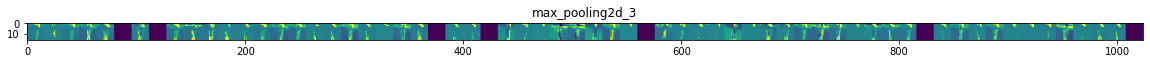

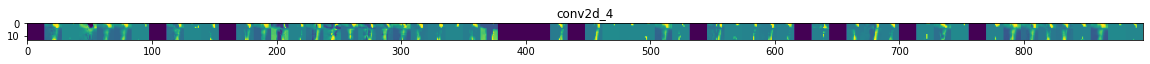

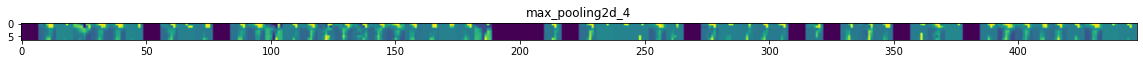

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

# Redesigning the Network with validation dataset
Now we will redesign the whole network incorporated with the validation set. 

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

--2020-07-13 15:58:32--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   124MB/s    in 1.1s    

2020-07-13 15:58:34 (124 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]



In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2020-07-13 15:57:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.28.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11480187 (11M) [application/zip]
Saving to: ‘/tmp/validation-horse-or-human.zip’

/tmp/validation-hor 100%[===================>]  10.95M  53.5MB/s    in 0.2s    

2020-07-13 15:57:36 (53.5 MB/s) - ‘/tmp/validation-horse-or-human.zip’ saved [11480187/11480187]



In [ ]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref =zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

In [ ]:
# directory with training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# directory with training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# directory with validation horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# directory with validation human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

In [ ]:
# some file names
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:10])

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:10])

validation_horse_names = os.listdir(validation_horse_dir)
print(validation_horse_names[:10])

validation_human_names = os.listdir(validation_human_dir)
print(validation_human_names[:10])

['horse34-8.png', 'horse40-2.png', 'horse38-7.png', 'horse31-3.png', 'horse14-1.png', 'horse21-6.png', 'horse02-5.png', 'horse35-4.png', 'horse35-8.png', 'horse40-4.png']
['human16-30.png', 'human09-01.png', 'human03-26.png', 'human11-05.png', 'human16-12.png', 'human13-10.png', 'human04-01.png', 'human07-13.png', 'human01-07.png', 'human16-03.png']
['horse4-439.png', 'horse1-000.png', 'horse1-510.png', 'horse1-568.png', 'horse3-440.png', 'horse2-112.png', 'horse3-469.png', 'horse2-040.png', 'horse2-314.png', 'horse4-014.png']
['valhuman05-21.png', 'valhuman01-20.png', 'valhuman01-24.png', 'valhuman05-14.png', 'valhuman01-08.png', 'valhuman01-00.png', 'valhuman05-11.png', 'valhuman05-02.png', 'valhuman01-01.png', 'valhuman04-09.png']


In [ ]:
# checking the total number of horse and human images in the directories
print('total taining horse images:', len(os.listdir(train_horse_dir)))
print('total taining human images:', len(os.listdir(train_human_dir)))
print('total validation horse images:', len(os.listdir(validation_horse_dir)))
print('total validation human images:', len(os.listdir(validation_human_dir)))

total taining horse images: 500
total taining human images: 527
total validation horse images: 128
total validation human images: 128


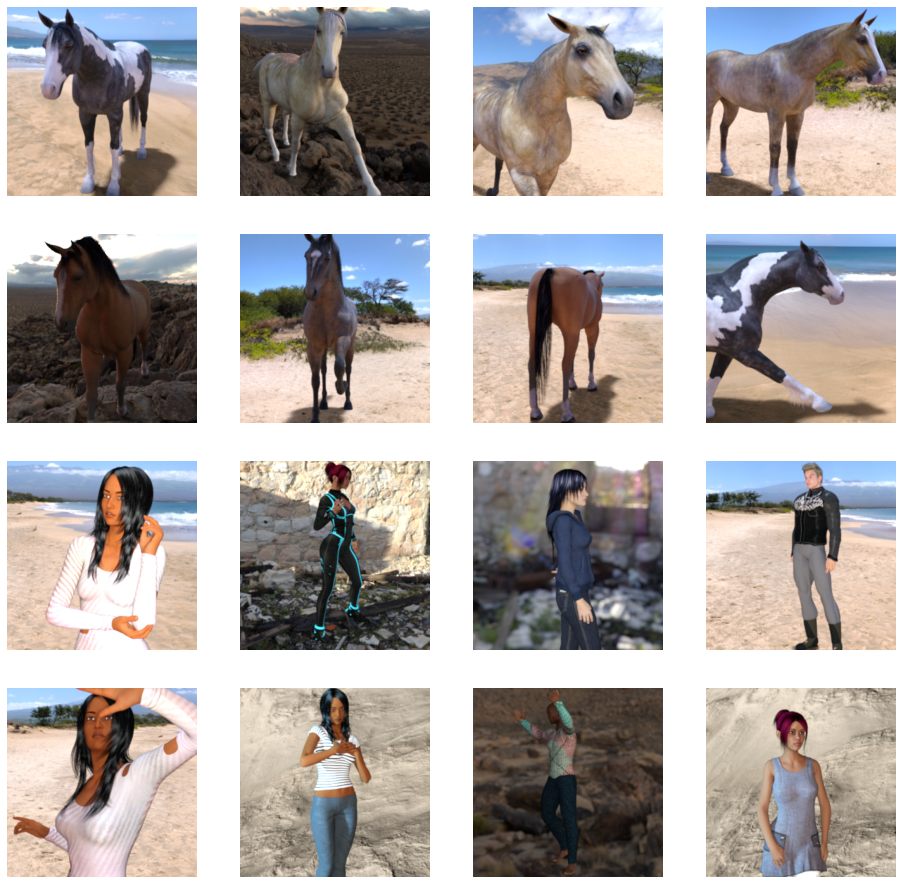

In [ ]:
# checking a few pictures
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# parameters for our graph
nrows = 4
ncols = 4

pic_index = 0

fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname)
                for fname in train_human_names[pic_index-8:pic_index]]
for i, img_path in enumerate(next_horse_pix+next_human_pix):
  sp = plt.subplot(nrows, ncols, i+1)
  sp.axis('off')
  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

In [ ]:
# Building our model
import tensorflow as tf

model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(300,300,3)),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2), 
        tf.keras.layers.Conv2D(64, (2,2), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 33, 33, 64)        3

In [ ]:
from tensorflow.keras.optimizers import RMSprop
model.compile(loss='binary_crossentropy', optimizer=RMSprop(lr=0.001), metrics=['accuracy'])

# Preprocessing the model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# rescale the images
train_datagen = ImageDataGenerator(rescale=1/255)
validation_datagen = ImageDataGenerator(rescale=1/255)

# flowing the training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    '/tmp/horse-or-human/',
    target_size=(300,300),
    batch_size=128,
    class_mode='binary')
# flowing the validation images in batches of 32 using the validation datagen generator
validation_generator = validation_datagen.flow_from_directory(
    '/tmp/validation-horse-or-human/',
    target_size=(300,300),
    batch_size=32,
    class_mode='binary')

Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


In [ ]:
# training the model
history = model.fit(train_generator, steps_per_epoch=8, epochs=20, verbose=1, validation_data=validation_generator, validation_steps=8)

Epoch 1/20
8/8 [==============================] - 7s 855ms/step - loss: 0.0079 - accuracy: 1.0000 - val_loss: 1.9237 - val_accuracy: 0.7891
Epoch 2/20
8/8 [==============================] - 7s 847ms/step - loss: 0.0067 - accuracy: 0.9967 - val_loss: 0.7735 - val_accuracy: 0.8672
Epoch 3/20
8/8 [==============================] - 7s 855ms/step - loss: 0.0690 - accuracy: 0.9755 - val_loss: 2.1942 - val_accuracy: 0.8047
Epoch 4/20
8/8 [==============================] - 8s 961ms/step - loss: 0.0035 - accuracy: 0.9989 - val_loss: 2.5734 - val_accuracy: 0.7930
Epoch 5/20
8/8 [==============================] - 7s 853ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.8459 - val_accuracy: 0.8047
Epoch 6/20
8/8 [==============================] - 7s 856ms/step - loss: 5.2090e-04 - accuracy: 1.0000 - val_loss: 2.1942 - val_accuracy: 0.8164
Epoch 7/20
8/8 [==============================] - 7s 854ms/step - loss: 2.2639e-04 - accuracy: 1.0000 - val_loss: 2.5922 - val_accuracy: 0.8008
Epoch 8/20
8

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded =files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300,300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + ' is a human')
  else:
    print(fn + ' is a horse')

Saving white-horse-black-and-white-photo-39070.jpg to white-horse-black-and-white-photo-39070 (1).jpg
[0.]
white-horse-black-and-white-photo-39070.jpg is a horse


Visualizing the intermediate representations

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in true_divide


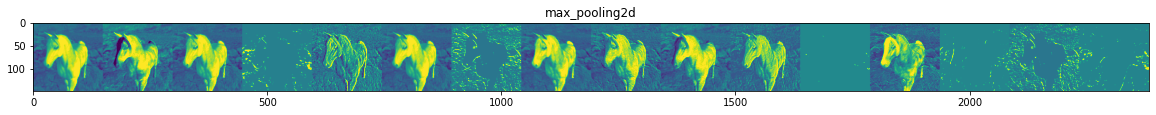

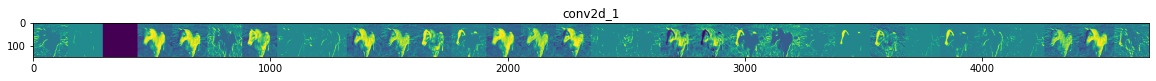

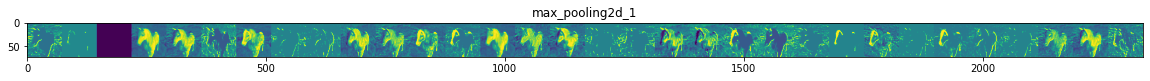

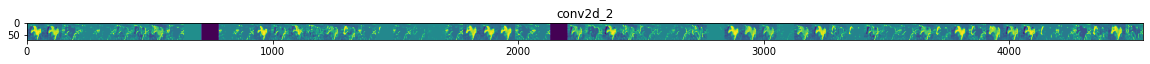

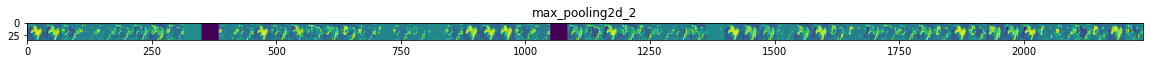

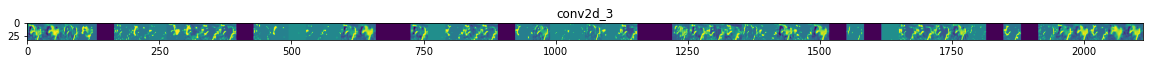

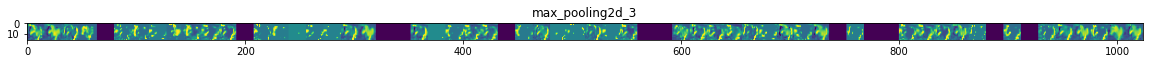

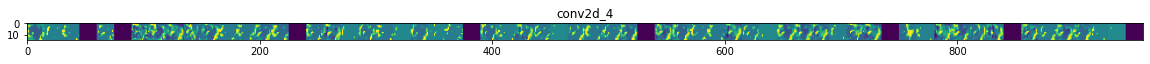

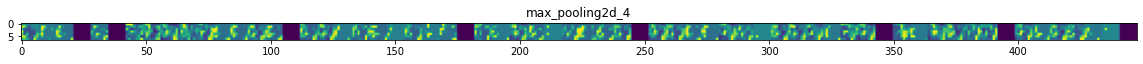

In [ ]:
import numpy as np
import random
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = tf.keras.models.Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
horse_img_files = [os.path.join(train_horse_dir, f) for f in train_horse_names]
human_img_files = [os.path.join(train_human_dir, f) for f in train_human_names]
img_path = random.choice(horse_img_files + human_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i]
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')